In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
N_CLASSES = 10
CUTS = 10
PREDICT_V = 'ClassId'
FILE_NAME = f'./data_{N_CLASSES}_{CUTS}_cuts.csv'
data = pd.read_csv(FILE_NAME)
print(f'{FILE_NAME}')

./data_10_10_cuts.csv


## **DATA PREPROCESSING**

In [ ]:
def get_normalize(data):
    X = data.iloc[:,:-2]        # feature columns
    X = (X-X.mean())/X.std()    # normalize data

    Y = data.iloc[:,-2:-1]      # predict variable column
    return X, Y

In [ ]:
X, Y = normalize(data)

### **DATA REPORTING**

In [ ]:
def data_reporting(X, Y):
    n, c = X.shape
    print(f'Training examples: {n}')
    for i in range(N_CLASSES):
        d0 = data[data[PREDICT_V] == i]
        r, c = d0.shape
        print(f'\tClass-id {i} : {r} \t{round(r*100/n)} %')

In [ ]:
# data_reporting(X, Y)

Training examples: 16237
	Class-id 0 : 195 	1 %
	Class-id 1 : 2158 	13 %
	Class-id 2 : 2466 	15 %
	Class-id 3 : 1599 	10 %
	Class-id 4 : 2239 	14 %
	Class-id 5 : 2210 	14 %
	Class-id 6 : 522 	3 %
	Class-id 7 : 1640 	10 %
	Class-id 8 : 1648 	10 %
	Class-id 9 : 1560 	10 %


In [ ]:
def K_Fold_Validation(classifier, X, Y):
    # get K folds index
    folds = 10
    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    k_fold_mean_score = 0

    model = classifier
    for train_index, test_index in kf.split(X):
        model = classifier
        model.fit(X.loc[train_index], Y.loc[train_index].values.ravel())
        predict = model.predict(X.loc[test_index])
        
        k_fold_mean_score += accuracy_score(Y.loc[test_index], predict)    

    k_fold_mean_score /= folds
    print(f'k-fold mean error:   {1 - k_fold_mean_score}')
    print(f'k-fold mean score:   {k_fold_mean_score}')

In [ ]:
def Bootstrap_Validation(classifier, X, Y, K=7):
    E = 10
    kf = KFold(n_splits=E)
    kf.get_n_splits(X)

    indexes = []
    for train_index, test_index in kf.split(X):
        indexes.append(np.array(test_index))
    indexes = np.array(indexes, dtype=object)
    bootstrap = 0
    for i in range(E):
        idx = np.random.choice(E, K, replace=True)
        not_idx = [i for i in range(E) if i not in idx]

        train_idx = np.concatenate(indexes[idx], axis=None)
        test_idx = np.concatenate(indexes[not_idx], axis=None)
        # print(idx, not_idx)

        model = classifier
        model.fit(X.loc[train_idx], Y.loc[train_idx].values.ravel())
        predict = model.predict(X.loc[test_idx])
        
        bootstrap += accuracy_score(Y.loc[test_idx], predict)
    bootstrap /= E
    print(f'bootstrap mean error:   {1 - bootstrap}')
    print(f'bootstrap mean score:   {bootstrap}')

In [ ]:
class Classifier():
    def __init__(self, model, dataset):
        self.X, self.Y = get_normalize(pd.read_csv(dataset))

    def experiment(self):
        pass

In [ ]:
model = LinearSVC(dual=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
model.fit(X_train, Y_train.values.ravel())
acc_score = model.score(X_test, Y_test)

In [ ]:
print(f'accuracy score: {acc_score}')

accuracy score: 0.3854679802955665


	accuracy on class 0-th: 0.0 %
	accuracy on class 1-th: 0.48536 %
	accuracy on class 2-th: 0.53918 %
	accuracy on class 3-th: 0.11345 %
	accuracy on class 4-th: 0.46549 %
	accuracy on class 5-th: 0.20346 %
	accuracy on class 6-th: 0.04192 %
	accuracy on class 7-th: 0.11905 %
	accuracy on class 8-th: 0.43763 %
	accuracy on class 9-th: 0.87294 %


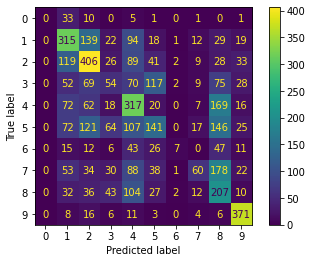

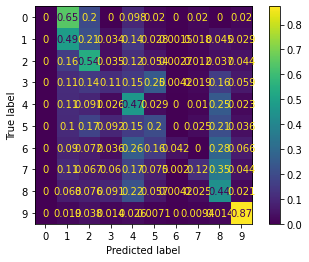

In [ ]:
# confussion matrix
cm = confusion_matrix(Y_test, model.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

cm_normalize = normalize(cm, norm='l1')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalize, display_labels=model.classes_)
disp.plot()

# accuracy report for each class
arr = np.array(cm)
for i in range(N_CLASSES):
    print(f'\taccuracy on class {i}-th: {round(arr[i,i]/np.sum(arr[i,:]), 5)} %')

In [ ]:
K_Fold_Validation(LinearSVC(dual=False), X, Y)
Bootstrap_Validation(LinearSVC(dual=False), X, Y)

k-fold mean error:   0.8203006200886882
k-fold mean score:   0.17969937991131185
bootstrap mean error:   0.8608971673119781
bootstrap mean score:   0.13910283268802198


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)
X = data.iloc[:,:-2]        # feature columns
Y = data.iloc[:,-2:-1]      # predict variable column

# normalize data
X = (X-X.mean())/X.std()

In [ ]:
K_Fold_Validation(LinearSVC(dual=False), X, Y)
Bootstrap_Validation(LinearSVC(dual=False), X, Y)

k-fold mean error:   0.6039296944477325
k-fold mean score:   0.3960703055522675
bootstrap mean error:   0.6064212801496887
bootstrap mean score:   0.39357871985031134
